# Understanding the local electricity market

## 📖 Background
You work for an energy company in Australia. Your company builds solar panel arrays and then sells the energy they produce to industrial customers. The company wants to expand to the city of Melbourne in the state of Victoria. 

Prices and demand for electricity change every day. Customers pay for the energy received using a formula based on the local energy market's daily price.

Your company's pricing committee wants your team to estimate energy prices for the next 12-18 months to use those prices as the basis for contract negotiations.

In addition, the VP of strategy is researching investing in storage capacity (i.e., batteries) as a new source of revenue. The plan is to store some of the energy produced by the solar panels when pricing conditions are unfavorable and sell it by the next day on the open market if the prices are higher.

## 💾 The data
You have access to over five years of energy price and demand data ([source](https://www.kaggle.com/aramacus/electricity-demand-in-victoria-australia)):

- "date" - from January 1, 2015, to October 6, 2020.
- "demand" - daily electricity demand in MWh.
- "price" - recommended retail price in AUD/MWh.
- "demand_pos_price" - total daily demand at a positive price in MWh.
- "price_positive" - average positive price, weighted by the corresponding intraday demand in AUD/MWh.
- "demand_neg_price" - total daily demand at a negative price in MWh.
- "price_negative" - average negative price, weighted by the corresponding intraday demand in AUD/MWh.
- "frac_neg_price" - the fraction of the day when the demand traded at a negative price.
- "min_temperature" - minimum temperature during the day in Celsius.
- "max_temperature" - maximum temperature during the day in Celsius.
- "solar_exposure" - total daily sunlight energy in MJ/m^2.
- "rainfall" - daily rainfall in mm.
- "school_day" - "Y" if that day was a school day, "N" otherwise.
- "holiday" - "Y" if the day was a state or national holiday, "N" otherwise.

Note: The price was negative during some intraday intervals, so energy producers were paying buyers rather than vice-versa.

## 💪 Competition challenge

Create a report that covers the following:

1. How do energy prices change throughout the year? Are there any patterns by season or month of the year?
2. Build a forecast of daily energy prices the company can use as the basis of its financial planning.
3. Provide guidance on how much revenue the energy storage venture could generate per year using retail prices and a 70MWh storage system.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt

In [2]:
df = pd.read_csv('./data/energy_demand.csv', parse_dates=['date'], index_col=['date'])
df.head()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2015-01-01,99635.030,25.633696,97319.240,26.415953,2315.790,-7.240000,0.020833,13.3,26.9,23.6,0.0,N,Y
2015-01-02,129606.010,33.138988,121082.015,38.837661,8523.995,-47.809777,0.062500,15.4,38.8,26.8,0.0,N,N
2015-01-03,142300.540,34.564855,142300.540,34.564855,0.000,0.000000,0.000000,20.0,38.2,26.5,0.0,N,N
2015-01-04,104330.715,25.005560,104330.715,25.005560,0.000,0.000000,0.000000,16.3,21.4,25.2,4.2,N,N
2015-01-05,118132.200,26.724176,118132.200,26.724176,0.000,0.000000,0.000000,15.0,22.0,30.7,0.0,N,N


In [3]:
df.tail()

,demand,price,demand_pos_price,price_positive,demand_neg_price,price_negative,frac_neg_price,min_temperature,max_temperature,solar_exposure,rainfall,school_day,holiday
date,,,,,,,,,,,,,
2020-10-02,99585.835,-6.076028,41988.240,26.980251,57597.595,-30.173823,0.625000,12.8,26.0,22.0,0.0,N,N
2020-10-03,92277.025,-1.983471,44133.510,32.438156,48143.515,-33.538025,0.583333,17.4,29.4,19.8,0.0,N,N
2020-10-04,94081.565,25.008614,88580.995,26.571687,5500.570,-0.163066,0.062500,13.5,29.5,8.4,0.0,N,N
2020-10-05,113610.030,36.764701,106587.375,39.616015,7022.655,-6.511550,0.083333,9.1,12.7,7.3,12.8,N,N
2020-10-06,122607.560,75.771059,122607.560,75.771059,0.000,0.000000,0.000000,8.9,12.6,5.8,1.0,N,N


### Observations:
The dataset does not have the entire year of 2020 data. It only has data up to *Oct 6th, 2020*

There are two general cases that depends on demand_neg_price:

When demand_neg_price is zero:

     Price(Retail) = Price Positive, demand = demand_pos_price
     
When demand_neg_price is no zero:
     
     demand = demand_pos_price + demand_neg_price
     price_neagtive = (df.demand * df.price - df.price_positive * df.demand_pos_price)/ df.demand_neg_price

In other words, when the supply exceed demand, it causes the negative price occure on the exceeding parts.

Let us calculate what is the percentage of with/without demand_neg_price over the entire dataset to evalute observations

In [4]:
#get the size as price matches price positive
s_p = df[df.price == df.price_positive].shape[0]

#get the size as price does not match price positive
s_n = df[df.price != df.price_positive]

print("The percentage of demand equals to demand positive on the entire dateset: {:.2f}, it has size of {}.".format(s_p/df.shape[0], s_p))
print("The percentage of demand does not equal to demand positive on the entire dateset: {:.2f}, it has size of {}.".format(s_n.shape[0]/df.shape[0], s_n.shape[0]))

The percentage of demand equals to demand positive on the entire dateset: 0.91, it has size of 1915.
The percentage of demand does not equal to demand positive on the entire dateset: 0.09, it has size of 191.


Let us check on our observation when demand_neg_price is no zero

1. demand = demand_pos_price + demand_neg_price

In [5]:
(s_n.demand == (s_n.demand_neg_price + s_n.demand_pos_price)).value_counts()

False    103
True      88
dtype: int64

2. price_neagtive = (df.demand * df.price - df.price_positive * df.demand_pos_price)/ df.demand_neg_price

In [6]:
(s_n.demand * s_n.price == (s_n.demand_neg_price * s_n.price_negative + s_n.demand_pos_price * s_n.price_positive)).value_counts()

False    151
True      40
dtype: int64

Surprisingly, the observation of non-zero negative prices is partially correct from the given dataset.

There are 88 out of 191 are correct for the first observation whereas 40 out of 191 are correct for the second observation. 

We are not sure yet how many of them satisfied both observations. This may lead us to model selections later.

It is interesting that we see that price has negative sign shown on the last 5 rows of data. Negaive sign on the price, which means the supplier pay for the payer to purchase or subsidize. 

Let us check how many of them which price negative in the dataset and follow our observation on demand_neg_price to check on price.

In [7]:
# negative sign on price
df_n = df[df.price < 0]
df_n.shape[0]

3

There is only 3 of sample in the entire dataset that has negative price.
From earlier calculation on percentage of binary cases of demand_negative_price, the supply exceeds the demand on electricity is less than 10% over past 5 years from 2015 to 2020. So what causes this 10% of dataset occures?

Let's check the entire dateset by doing Exploratory Data Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2106 entries, 2015-01-01 to 2020-10-06
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   demand            2106 non-null   float64
 1   price             2106 non-null   float64
 2   demand_pos_price  2106 non-null   float64
 3   price_positive    2106 non-null   float64
 4   demand_neg_price  2106 non-null   float64
 5   price_negative    2106 non-null   float64
 6   frac_neg_price    2106 non-null   float64
 7   min_temperature   2106 non-null   float64
 8   max_temperature   2106 non-null   float64
 9   solar_exposure    2105 non-null   float64
 10  rainfall          2103 non-null   float64
 11  school_day        2106 non-null   object 
 12  holiday           2106 non-null   object 
dtypes: float64(11), object(2)
memory usage: 230.3+ KB


In [9]:
df.isnull().sum()

demand              0
price               0
demand_pos_price    0
price_positive      0
demand_neg_price    0
price_negative      0
frac_neg_price      0
min_temperature     0
max_temperature     0
solar_exposure      1
rainfall            3
school_day          0
holiday             0
dtype: int64

In [10]:
# the missing value is small portion in the entire datesets, it is either 3 or 4, let us drop the missing value and see
df = df.dropna()
df.isnull().sum()

demand              0
price               0
demand_pos_price    0
price_positive      0
demand_neg_price    0
price_negative      0
frac_neg_price      0
min_temperature     0
max_temperature     0
solar_exposure      0
rainfall            0
school_day          0
holiday             0
dtype: int64

In [11]:
#change school_day & holiday to binary, N->0, Y->1
binary = {'N':0, "Y":1}

#apply the binary dictionary into pandas
df.school_day = df.school_day.apply(lambda x:binary[x])
df.holiday = df.holiday.apply(lambda x:binary[x])

In [12]:
#create a weekday column
df['weekday'] = df.index.weekday

We are interested in finding the patterns on the price through out a year. Let us get an average value on each feature in each month of a year and visualize them.

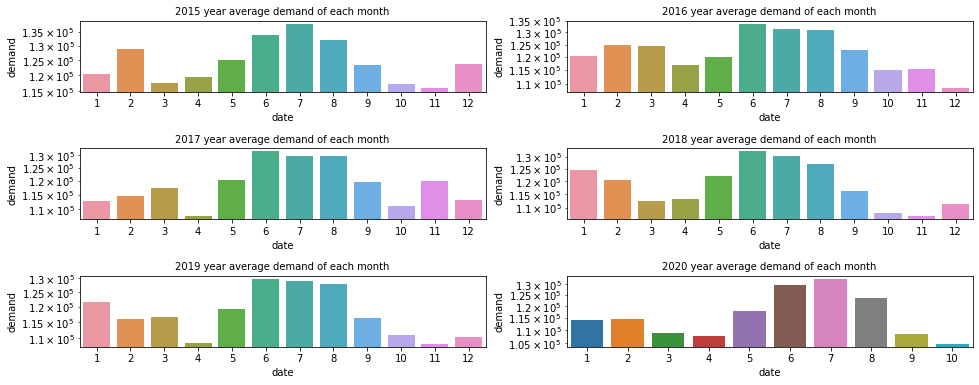

In [14]:
#groupby year and month to generate average value in each columns
df_avg = df.groupby(pd.Grouper(freq='M')).mean()

#get the unique year and convert to string for slicing
year_list = [str(i) for i in np.unique(df_avg.index.year)]

# create nrow and ncols for ploting
nrows= 3
ncols = len(year_list)//nrows
plt.figure(figsize = (16,6))

#plot each month demand of each year
for indx, yr in enumerate(year_list):
    ax = plt.subplot(nrows, ncols, indx + 1) 
    #get each year
    df = df_avg[yr]
    sns.barplot(ax= ax, data= df, x=df.index.month, y="demand")
    #set the demand in log scale since the value is big
    ax.set_yscale("log")
    ax.set_title(yr + " year average demand of each month", fontsize=10)
    

plt.subplots_adjust(hspace=0.8)
plt.show()

From average demand bar graphs of each month, there is an inceasing demanding on power consumption starts from April, reaches to its peak either June or Junly, then descreases.

Before exploring further, here are some [season](https://www.australia.com/en-ca/facts-and-planning/weather-in-australia.html#:~:text=Australia's%20seasons%20are%20at%20opposite,September%20to%20November%20is%20spring.) information in Australia.
   - Summer: Dec - Feb 
   - Fall: Mar - May
   - Winter: June - Aug
   - Spring: Sept - Nov
    
In terms of season, June - August, Winter, the cold season could be one of factors that increasing the usage on electricity. To have a clear understanding on seasonal demanding for electricity, let' plot average demands on electricity by the season in Australia. Since year 2020 does not have entire full dataset over the year, we check on 2016-2019 to discover the general patterns.

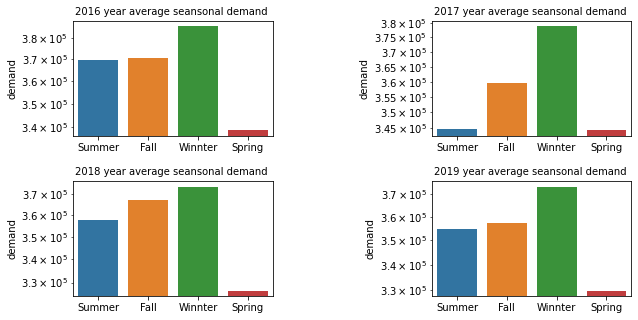

In [15]:
plt.figure(figsize = (10,8))
season_n = ["Summer", "Fall", "Winnter", "Spring"]
#get 2015 - 2019 monthly data based on Australia season
df_avg_season = df_avg['2015-12':'2019-11']

#plot each month demand of each year
for indx, yr in enumerate(year_list[1:-1]):
    ax = plt.subplot(nrows, ncols, indx + 1) 
    #get each year
    df = df_avg[yr]
    
    #reset index, calculate the each season total average power demand over a year
    df_season_avg = df.reset_index()[['demand']]
    df_season_avg = df_season_avg.groupby(df_season_avg.index //3).sum()
    
    sns.barplot(ax= ax, data= df_season_avg, x=df_season_avg.index, y="demand")
    #set the demand in log scale since the value is big
    ax.set_yscale("log")
    ax.set_title(yr + " year average seansonal demand ", fontsize=10)
    ax.set_xticklabels(season_n)

plt.subplots_adjust(
                    wspace= 0.8,
                    hspace= 0.4)
plt.show()

The average seasonal demanding of power in Australia from 2016 - 2019 shows a general patterns that the demand on power is getting higher after Spring and reach to the peak in Winter. Spring has the lowest power demanding over the a year. 
The weather of each season play significant role on the power needs. 

In general, when the demand is high, the price would go up and vice versa. Let us check if the price follows this pattern based on this from 2016 -2019 on Australia season.

## 🧑‍⚖️ Judging criteria

| CATEGORY | WEIGHTING | DETAILS                                                              |
|:---------|:----------|:---------------------------------------------------------------------|
| **Recommendations** | 35%       | <ul><li>Clarity of recommendations - how clear and well presented the recommendation is.</li><li>Quality of recommendations - are appropriate analytical techniques used & are the conclusions valid?</li><li>Number of relevant insights found for the target audience.</li></ul>       |
| **Storytelling**  | 35%       | <ul><li>How well the data and insights are connected to the recommendation.</li><li>How the narrative and whole report connects together.</li><li>Balancing making the report in-depth enough but also concise.</li></ul> |
| **Visualizations** | 20% | <ul><li>Appropriateness of visualization used.</li><li>Clarity of insight from visualization.</li></ul> |
| **Votes** | 10% | <ul><li>Up voting - most upvoted entries get the most points.</li></ul> |

## ✅ Checklist before publishing into the competition
- Rename your workspace to make it descriptive of your work. N.B. you should leave the notebook name as notebook.ipynb.
- **Remove redundant cells** like the judging criteria, so the workbook is focused on your story.
- Make sure the workbook reads well and explains how you found your insights. 
- Try to include an **executive summary** of your recommendations at the beginning.
- Check that all the cells run without error.

## ⌛️ Time is ticking. Good luck!